<a href="https://colab.research.google.com/github/fatiihnaz/MPA-MLF-Naz/blob/main/Lab_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPA-MLF, Lab 6 - Feedforward Neural Networks with regularization techniques and hyperparameter tunning

## Exercise 1 - Classification of an images

The goal of this task will be to create Multi-layer perceptron model, that is able to recognize the  CIFAR10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). The CIFAR10 dataset consist of 60000 images with resolution of 32x32 pixels. There are 10 classes in total - *airplane*, *automobile*, *bird*, *cat*, *deer*, *dog*, *frog*, *horse*, *ship*, *truck*

These is an example of the dataset:

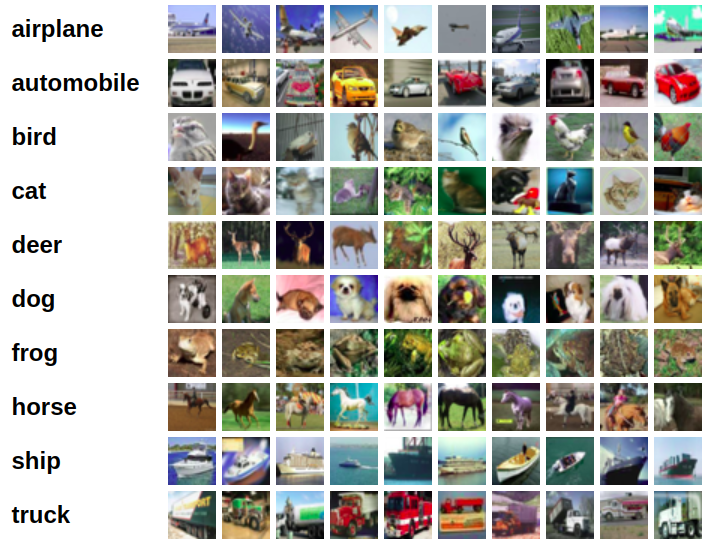

### 0. Import libraries

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

### 1. Load the Dataset
The dataset is already a part of the Keras library, so we can quickly load it using the following command

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


The following numbered labels represent the labels in the dataset:

In [5]:
labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

### 2. Data Examination

Fistly, lets have a look and the couple of images we have,

In [6]:
def display_random_images(x_data: np.array, y_data: np.array, count: int = 10) -> None:
  index = np.array(len(x_data))
  selected_ind = np.random.choice(index, count)

  selected_img = x_data[selected_ind]
  selected_labels_encoded = y_data[selected_ind]
  selected_labels = [labels[x[0]] for x in selected_labels_encoded]

  concat_img = np.concatenate(selected_img, axis=1)

  plt.figure(figsize=(20,10))
  plt.imshow(concat_img)

  for id_label, label in enumerate(selected_labels):
    plt.text((32/2) + 32*id_label - len(label), 32*(5/4), label)
  plt.axis('off')
  plt.show()



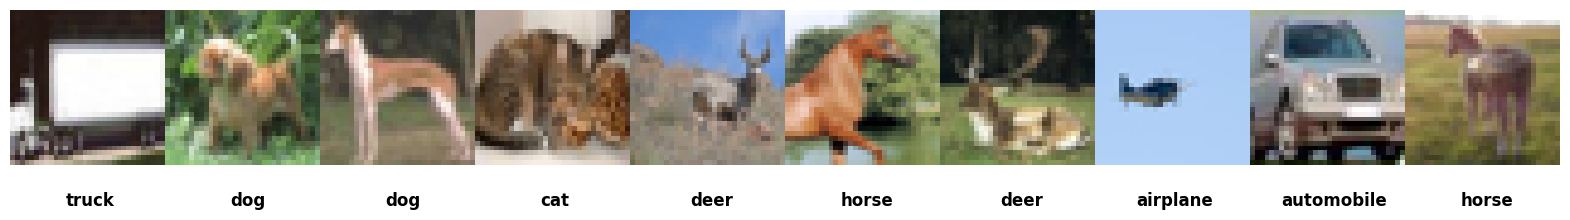

In [ ]:
display_random_images(X_train, y_train)

In [7]:
#check the shape of image dataset

X_train.shape

(50000, 32, 32, 3)

In our dataset, we have 60000 images with 32x32 resolution. Each image has three channels (R, G, B). We have 50000 images for training and 10000 images for testing. Each channel for each image has values from 0 - 255, where each number represents the pixel intensity.
With the combination of intensities of R, G and B, you can display up to 16,777,216 different colours (256^3)

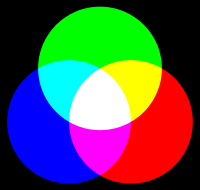

Here you can display each channel separately:

In [8]:
def display_channels_separately(image: np.array) -> None:

  plt.figure()
  fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))


  axs[0].imshow(image[:,:,0],cmap='Reds')
  axs[1].imshow(image[:,:,1],cmap='Blues')
  axs[2].imshow(image[:,:,2],cmap='Greens')

  axs[3].imshow(image)

  plt.show()

<Figure size 640x480 with 0 Axes>

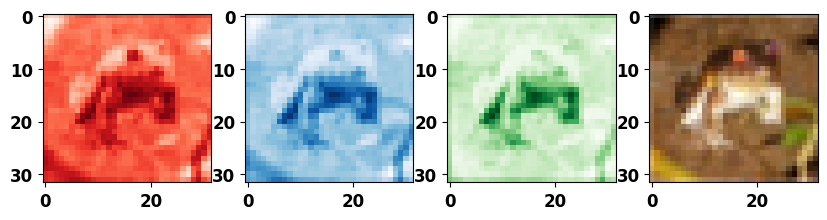

In [9]:
display_channels_separately(X_train[0])

### 3. Preprocessing of the images

For machine learning purposes, we have to preprocess our images. Firstly we need to scale our images, to scale intensity values from 0-1 (min-max scaling)

In [10]:
X_train_scaled = X_train.astype('float32') / 255.0

We need to one-hot-encode the labels in our ground truth variable as our second preprocessing.

In [11]:
y_train_encoded = to_categorical(y_train, num_classes=10)

### 4. Define the model architecture

In [12]:
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We will define *the Sequential* model as in our last exercise. This time we will use a different approach to determine the input layers. Instead of specifying the *input_dim* parameter in our first hidden layer, we will create a **Flatten** layer that takes our 32x32x3 image and reshapes it into 1x3072.

We will specify ten neurons in our output layer because we have 10 possible outputs and a **softmax** activation function that returns us a probability distribution over the classes. The class with the highest probability is typically chosen as the predicted class for a given input.

Check the description of our model:

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,634 (1.51 MB)

 Trainable params: 394,634 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

The next step is to compile our model, we will use *categorical_crossentropy* as a loss function, *stochastic gradient descend* as an optimisation and we will be checking *the accuracy* metric.

In [14]:
optimizer = SGD(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### 5. Train the model

Our model will be trained in the same way as in our last pc_labs,

In [15]:
history = model.fit(X_train_scaled, y_train_encoded, epochs=20, batch_size=128, validation_split = 0.2)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1029 - loss: 2.4026 - val_accuracy: 0.1175 - val_loss: 2.2982
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1254 - loss: 2.2909 - val_accuracy: 0.1465 - val_loss: 2.2724
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1597 - loss: 2.2660 - val_accuracy: 0.1760 - val_loss: 2.2508
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.1931 - loss: 2.2465 - val_accuracy: 0.2055 - val_loss: 2.2312
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.2169 - loss: 2.2270 - val_accuracy: 0.2289 - val_loss: 2.2132
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2422 - loss: 2.2061 - val_accuracy: 0.2455 - val_loss: 2.1968
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.2499 - loss: 2.1930 - val_accuracy: 0.2594 - val_loss: 2.1817
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2602 - loss: 2.1774 - val_accura

### 6. Model evaluation

In [16]:
X_test = X_test.astype('float32') / 255.0
y_test_encoded = to_categorical(y_test, num_classes=10)

In [17]:
score = model.evaluate(X_test, y_test_encoded, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

Test loss: 2.052144765853882
Test accuracy: 31.51000142097473 %


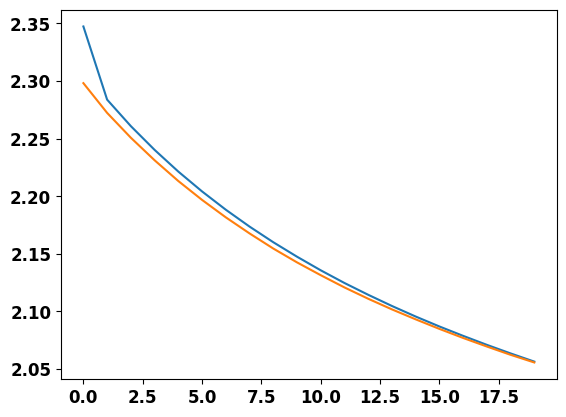

In [18]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

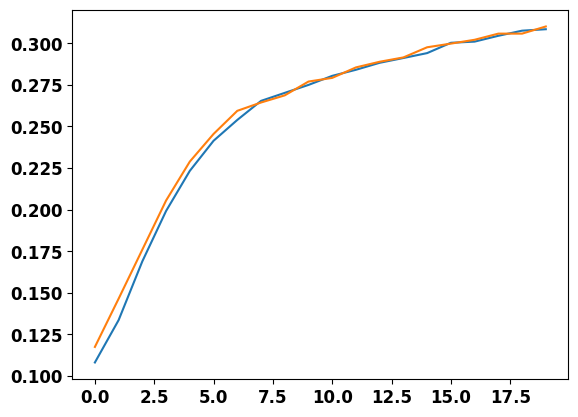

In [19]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

As you can see from the evaluation above, we was able to achive approx. 30% of an accuracy. In other word approx. 70% of an images we classified wrongly. That is really bad!

Lets check the best predictions from our model:

In [20]:
def show_the_best_predictions(model, x_test: np.array, y_test: np.array, n_of_pred: int = 10) -> None:
  mapping = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

  predictions = model.predict(x_test)
  y_test = y_test.reshape(1,-1)
  predictions_ind = np.argmax(predictions, axis=1)
  predictions_ind = predictions_ind.reshape(1, -1)

  corect_predictions = np.where(predictions_ind == y_test)

  rows_correct = corect_predictions[1]
  predictedtions_correct = predictions[rows_correct]
  target_correct = y_test[0][rows_correct]

  max_samples = predictions[rows_correct, target_correct]
  selected_images = x_test[rows_correct]
  sorted_ind = np.argsort(max_samples)[::-1]


  images = []
  prob = []
  labels = []


  for ind in range(n_of_pred):

    index = sorted_ind[ind]

    labels.append(target_correct[index])
    prob.append(max_samples[index])
    images.append(selected_images[index])

  plt.figure(figsize=(20,10))

  images = np.concatenate(np.asarray(images),axis=1)
  plt.imshow(images)
  for ins in range(n_of_pred):
    texts = '{}: \n{:.3f} %'.format(mapping[labels[ins]], prob[ins]*100)
    plt.text((32/2) + 32*ins - len(mapping[labels[ins]]), 32*(5/4), texts)

  plt.axis('off')
  plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


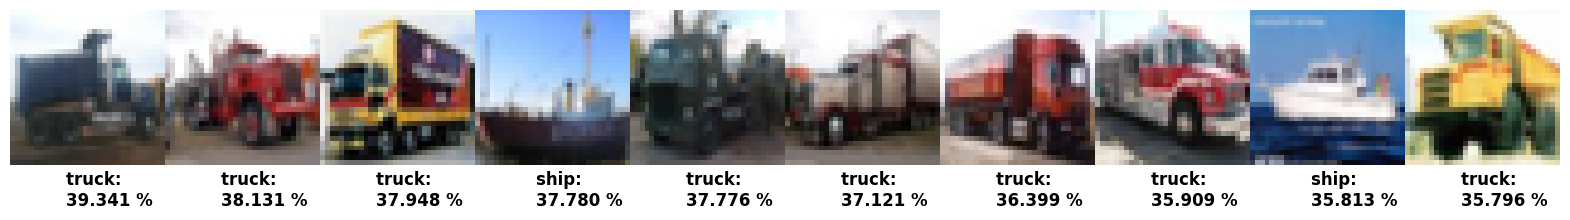

In [21]:
show_the_best_predictions(model, X_test, y_test)

### Task Description:

You task of this exercise would be to improve the model's performance to achieve better results in image classification task. There is no need to change the preprocessing of the dataset. There are possible way how to improve the models performance:

1. Hyperparameter tunning - change the hyperparameters so that the model will perform better. You can experiment with the following:
 - *changing the number of neurons in the hidden layer*
 - *changing the number of hidden layers*
 - *changing the activation functions*
 - *changing the learning rate*
 - *changing the optimizer* - So far, we have used only Gradient descend as our optimizer, but Keras offers other algorithms that can perform better - check the documentation!
 - *changing the number of learning epochs*\
 - *changing the batch size*

2. Regularization techniques - There are several regularization techniques that can improve the model's performance:
 - *Dropout* -  In the Keras lib. you can add *dropout layer* into your Sequential model using the following command  *model.add(Dropout(p))* where *p* is an hyperparameter that controls dropout probabily, typical values are 0.1 - 0.5.
 - *L1, L2 regularization* - In keras the regularization is applied for selected layers, there is an example how to add l2 regularization to an layer (for more details check the documnetation):  *model.add(Dense(64, activation='relu', input_dim=100, kernel_regularizer=l2(0.01)))*
 - *Early stopping* -  In Keras, you can use the EarlyStopping callback to implement early stopping in your model. *early_stopping = EarlyStopping(monitor='val_loss', patience=3)*,  *model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])*


Try to make the highest testing accuracy possible. You can directly edit the code that is presented above, or you can copy everything into new cells. Please submit only the code with the best performance and briefly describe what approaches you have tried and what were the results

### WRITE YOUR DESCRIPTION IN THIS CELL ###

In [22]:
from tensorflow.keras import models, layers, regularizers, optimizers

def build_mlp(neurons=256,
              hidden_layers=2,
              dropout_rate=0.3,
              learning_rate=1e-3,
              l2_reg=1e-3):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(32, 32, 3)))
    for _ in range(hidden_layers):
        model.add(layers.Dense(neurons,
                               activation='relu',
                               kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [23]:
import random, pandas as pd, numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Pre‑scale data once
X_train_scaled = X_train.astype('float32') / 255.0
X_test_scaled  = X_test.astype('float32') / 255.0
y_train_encoded = to_categorical(y_train, num_classes=10)
y_test_encoded  = to_categorical(y_test,  num_classes=10)

space = {
    'neurons': [128, 256, 512],
    'hidden_layers': [1, 2, 3],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [3e-4, 1e-3, 3e-3],
    'l2_reg': [1e-4, 1e-3]
}

def random_choice(d):
    return {k: random.choice(v) for k, v in d.items()}

trials = 8
results = []

for t in range(trials):
    params = random_choice(space)
    model_rs = build_mlp(**params)
    es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=0)
    hist = model_rs.fit(
        X_train_scaled, y_train_encoded,
        epochs=25, batch_size=64,
        validation_split=0.2,
        callbacks=[es],
        verbose=0)
    best_acc = max(hist.history['val_accuracy'])
    results.append({**params, 'val_accuracy': best_acc, 'model': model_rs})
    print(f"Trial {t+1}/{trials} — best val_acc: {best_acc:.4f}")

df_results = pd.DataFrame(results).sort_values('val_accuracy', ascending=False)
df_results[['neurons','hidden_layers','dropout_rate','learning_rate','l2_reg','val_accuracy']].head()


Trial 1/8 — best val_acc: 0.4792
Trial 2/8 — best val_acc: 0.2278
Trial 3/8 — best val_acc: 0.4257
Trial 4/8 — best val_acc: 0.4026
Trial 5/8 — best val_acc: 0.2508
Trial 6/8 — best val_acc: 0.4407
Trial 7/8 — best val_acc: 0.5096
Trial 8/8 — best val_acc: 0.2023


,neurons,hidden_layers,dropout_rate,learning_rate,l2_reg,val_accuracy
6,512,2,0.2,0.0003,0.0010,0.5096
0,512,3,0.3,0.0003,0.0001,0.4792
5,128,2,0.3,0.0003,0.0010,0.4407
2,512,3,0.4,0.0003,0.0010,0.4257
3,512,3,0.2,0.0010,0.0010,0.4026


from matplotlib import pyplot as plt
_df_0['neurons'].plot(kind='hist', bins=20, title='neurons')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['hidden_layers'].plot(kind='hist', bins=20, title='hidden_layers')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['dropout_rate'].plot(kind='hist', bins=20, title='dropout_rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['learning_rate'].plot(kind='hist', bins=20, title='learning_rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='neurons', y='hidden_layers', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='hidden_layers', y='dropout_rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='dropout_rate', y='learning_rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='learning_rate', y='l2_reg', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['learning_rate']
  ys = series['neurons']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('learning_rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('learning_rate')
_ = plt.ylabel('neurons')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['learning_rate']
  ys = series['hidden_layers']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('learning_rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('learning_rate')
_ = plt.ylabel('hidden_layers')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['learning_rate']
  ys = series['dropout_rate']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('learning_rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('learning_rate')
_ = plt.ylabel('dropout_rate')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['learning_rate']
  ys = series['l2_reg']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('learning_rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('learning_rate')
_ = plt.ylabel('l2_reg')

from matplotlib import pyplot as plt
_df_12['neurons'].plot(kind='line', figsize=(8, 4), title='neurons')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['hidden_layers'].plot(kind='line', figsize=(8, 4), title='hidden_layers')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['dropout_rate'].plot(kind='line', figsize=(8, 4), title='dropout_rate')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['learning_rate'].plot(kind='line', figsize=(8, 4), title='learning_rate')
plt.gca().spines[['top', 'right']].set_visible(False)

In [24]:
best_model = df_results.iloc[0]['model']
test_loss, test_acc = best_model.evaluate(X_test.astype('float32')/255.0,
                                          to_categorical(y_test, num_classes=10),
                                          verbose=0)
print(f"Best validation accuracy: {df_results.iloc[0]['val_accuracy']:.4f}")
print(f"Test accuracy with best model: {test_acc:.4f}")

Best validation accuracy: 0.5096
Test accuracy with best model: 0.1000


### Voluntary task:
Implement one of the hyperparameter tunning algorithms discussed in the lecture, such as *Grid Search*, *Random Search* or more sophisticated ones. Some of these algorithms are already included in the Keras. Check the documentation